In [1]:
!pip install contractions
!pip install fuzzywuzzy
!pip install pot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 13.6 MB/s eta 0:00:00


In [2]:
# Import Libraries

import pandas as pd
import numpy as np

import re
import contractions
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from ot import emd2

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
colors = ['firebrick', 'tomato']

import gc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Load the data

df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')
df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question_len_diff
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37


In [4]:
df.shape

(404266, 8)

## **Data Preparation**

---



In [5]:
X = df.drop(['is_duplicate', 'qid1', 'qid2'], axis =1)
y = df['is_duplicate']

# Split the data into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y) # 70 % train, 30 % test

# Create DataFrames for training, test, and validation sets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Print the shapes of the resulting sets
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (282986, 6)
Test set shape: (121280, 6)


## **Preprocessing**

In [6]:
# Define a function that replaces numbers with string equivalents
def replace_numbers(match):
    number = match.group(0)
    if number.endswith('000000000'):
        return number[:-9] + 'b'
    elif number.endswith('000000'):
        return number[:-6] + 'm'
    elif number.endswith('000'):
        return number[:-3] + 'k'
    else:
        return number

# Define a function that performs preprocessing on the text data
def preprocess(q):
    q = q.lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents
    q = re.sub(r'\b[0-9]+(000000000|000000|000)\b', replace_numbers, q)

    # Decontracting words
    q = contractions.fix(q)

    try:
        # Removing HTML tags
        q = BeautifulSoup(q, features="html.parser").get_text()
    except:
        pass

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q)

    # Tokenization and POS tagging
    tokens = word_tokenize(q)
    pos_tags = nltk.pos_tag(tokens)

    # Remove stop words and lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word, pos in pos_tags if word not in stop_words]

    return tokens, pos_tags

In [7]:
# Preprocess the data and obtain the tokens and POS tags for train_df

train_df['tokens_q1'], train_df['pos_tags_q1'] = zip(*train_df['question1'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))
train_df['tokens_q2'], train_df['pos_tags_q2'] = zip(*train_df['question2'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))

# Preprocess the data and obtain the tokens and POS tags for test_df

test_df['tokens_q1'], test_df['pos_tags_q1'] = zip(*test_df['question1'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))
test_df['tokens_q2'], test_df['pos_tags_q2'] = zip(*test_df['question2'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))


In [8]:
# Sample of the preprocessed data

train_df[['question1', 'tokens_q1', 'pos_tags_q1', 'question2', 'tokens_q2', 'pos_tags_q2']].head(3)

,question1,tokens_q1,pos_tags_q1,question2,tokens_q2,pos_tags_q2
283707,What is the fastest way to memorise a huge amo...,"[fastest, way, memorise, huge, amount, text, e...","[(what, WP), (is, VBZ), (the, DT), (fastest, J...",What is the best and fastest way to memorize a...,"[best, fastest, way, memorize, lot, material, ...","[(what, WP), (is, VBZ), (the, DT), (best, JJS)..."
353488,"When Marie Antoinette famously didn't say, ""Le...","[marie, antoinette, famously, say, let, eat, c...","[(when, WRB), (marie, NN), (antoinette, NN), (...",Do NMAT and SNAP have Algebra in its?,"[nmat, snap, algebra]","[(do, VB), (nmat, NNS), (and, CC), (snap, NNS)..."
399407,What are some tips on making it through the jo...,"[tip, making, job, interview, process, capital...","[(what, WDT), (are, VBP), (some, DT), (tips, N...",What are some tips on making it through the jo...,"[tip, making, job, interview, process, bank, h...","[(what, WDT), (are, VBP), (some, DT), (tips, N..."


In [9]:
gc.collect()

0

**Word Cloud for 'tokens_q1' and 'tokens_q2'**

Train

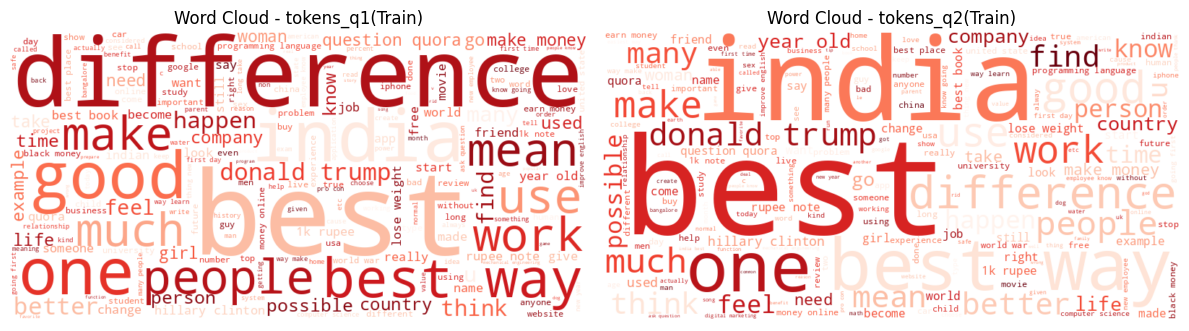

In [10]:
# Join tokens to form strings
tokens_q1_str1 = [' '.join(tokens) for tokens in train_df['tokens_q1']]
tokens_q2_str1 = [' '.join(tokens) for tokens in train_df['tokens_q2']]

# Generate word clouds for 'tokens_q1' and 'tokens_q2'
wordcloud_q1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(tokens_q1_str1))
wordcloud_q2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(tokens_q2_str1))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_q1, interpolation='bilinear')
plt.title("Word Cloud - tokens_q1(Train)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_q2, interpolation='bilinear')
plt.title("Word Cloud - tokens_q2(Train)")
plt.axis("off")

plt.tight_layout()
plt.show()


Test

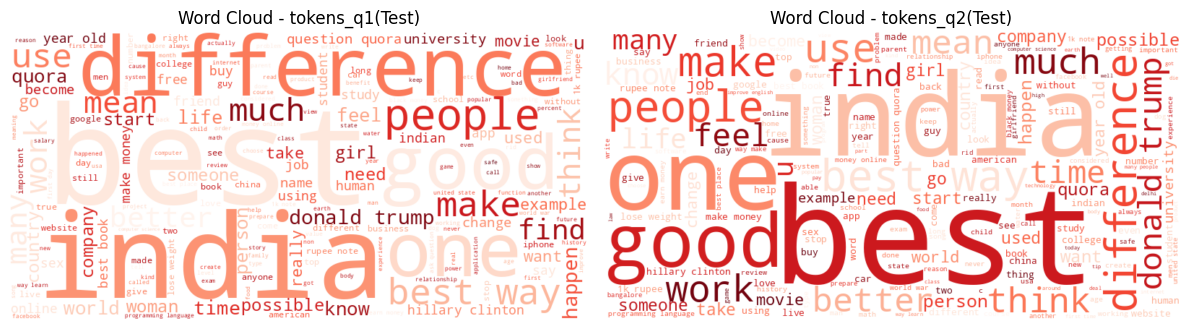

In [11]:
# Join tokens to form strings
tokens_q1_str2 = [' '.join(tokens) for tokens in test_df['tokens_q1']]
tokens_q2_str2 = [' '.join(tokens) for tokens in test_df['tokens_q2']]

# Generate word clouds for 'tokens_q1' and 'tokens_q2'
wordcloud_q1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(tokens_q1_str2))
wordcloud_q2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(tokens_q2_str2))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_q1, interpolation='bilinear')
plt.title("Word Cloud - tokens_q1(Test)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_q2, interpolation='bilinear')
plt.title("Word Cloud - tokens_q2(Test)")
plt.axis("off")

plt.tight_layout()
plt.show()

### **Feature Engineering**

In [12]:
def add_additional_features(df):

    # Length of tokens
    df['tokens_len1'] = df['tokens_q1'].apply(len)
    df['tokens_len2'] = df['tokens_q2'].apply(len)
    df['tokens_len_diff'] = abs(df['tokens_len1'] - df['tokens_len2'])

    # Average token length
    df['avg_token_len1'] = df['tokens_q1'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
    df['avg_token_len2'] = df['tokens_q2'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)

    # N-gram similarity
    def compute_ngram_similarity(tokens_q1, tokens_q2, n):
        ngrams_q1 = set(nltk.ngrams(tokens_q1, n))
        ngrams_q2 = set(nltk.ngrams(tokens_q2, n))
        if len(ngrams_q1) == 0 and len(ngrams_q2) == 0:
            return 0
        common_ngrams = ngrams_q1.intersection(ngrams_q2)
        similarity = len(common_ngrams) / (len(ngrams_q1) + len(ngrams_q2))
        return similarity

    df['bigram_similarity'] = df.apply(lambda row: compute_ngram_similarity(row['tokens_q1'], row['tokens_q2'], n=2), axis=1)
    df['trigram_similarity'] = df.apply(lambda row: compute_ngram_similarity(row['tokens_q1'], row['tokens_q2'], n=3), axis=1)

    # Fuzzy ratio
    df['fuzzy_ratio'] = df.apply(lambda row: fuzz.ratio(row['question1'], row['question2']), axis=1)

    # Partial ratio
    def partial_ratio(row):
      text1 = set(row['question1'])
      text2 = set(row['question2'])
      return fuzz.partial_ratio(text1,text2)

    df['partial_ratio'] = df.apply(partial_ratio, axis=1)

    # Token set ratio
    def token_set_ratio(row):
      text1 = set(row['question1'])
      text2 = set(row['question2'])
      return fuzz.token_set_ratio(text1,text2)

    df['token_set_ratio'] = df.apply(token_set_ratio, axis=1)

    # Token sort ratio
    def token_sort_ratio(row):
      text1 = set(row['question1'])
      text2 = set(row['question2'])
      return fuzz.token_sort_ratio(text1,text2)

    df['token_sort_ratio'] = df.apply(token_sort_ratio, axis=1)

    # Sentence count
    df['sentence_count1'] = df['question1'].apply(lambda x: len(sent_tokenize(x)))
    df['sentence_count2'] = df['question2'].apply(lambda x: len(sent_tokenize(x)))

    # Number of capital letters and question marks
    df['num_capital_letters1'] = df['question1'].apply(lambda x: sum(1 for char in x if char.isupper()))
    df['num_capital_letters2'] = df['question2'].apply(lambda x: sum(1 for char in x if char.isupper()))
    df['num_question_marks1'] = df['question1'].apply(lambda x: x.count('?'))
    df['num_question_marks2'] = df['question2'].apply(lambda x: x.count('?'))

    return df

In [ ]:
# Generate new columns based on the tokens

train_df = add_additional_features(train_df)
test_df = add_additional_features(test_df)

In [ ]:
# Print sample of features

print(train_df.sample(3))
print(test_df.sample(3))

In [ ]:
gc.collect()

In [ ]:
# Display summary statistics

train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
# Display rows with zero tokens

zero_tokens_rows = train_df[(train_df['tokens_q1_len'] == 0) | (train_df['tokens_q2_len'] == 0) ]

print(len(zero_tokens_rows))
print(zero_tokens_rows)

In [ ]:
zero_tokens_rows2 = test_df[(test_df['tokens_q1_len'] == 0) |(test_df['tokens_q2_len'] == 0) ]

print(len(zero_tokens_rows2))
print(zero_tokens_rows2)

In [ ]:
# Drop the zero token row

train_df = train_df.drop(zero_tokens_rows.index)
test_df = test_df.drop(zero_tokens_rows2.index)

print(train_df.shape)
print(test_df.shape)

In [ ]:
gc.collect()

In [ ]:
# Save preprocessed train and test set to a csv file

train_df.to_csv('preprocessed_train.csv', index = False)
test_df.to_csv('preprocessed_test.csv', index = False)

### **GloVe Embeddings**

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [ ]:
glove_file = '/content/drive/MyDrive/embeddings/glove.6B.300d.txt'
word2vec_file = 'glove.6B.300d.word2vec'  # Output file for converted word2vec format

# Convert the GloVe file to the word2vec format
glove2word2vec(glove_file, word2vec_file)
wv = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

# Total number of vocabulary words in the pretrained model
vocab_size = len(wv.index_to_key)
print("Vocabulary size:", vocab_size)

# Dimensionality of the word vectors
vector_dim = wv.vector_size
print("Vector dimension:", vector_dim)


**Cosine Similarity**

In [ ]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

# Function that computes similarity between the tokens and the word vectors
def compute_similarity(df, tokens_q1, tokens_q2, wv, vector_dim):
    similarities = []

    for tokens1, tokens2 in zip(tokens_q1, tokens_q2):
        embedding1 = np.zeros((vector_dim,))
        embedding2 = np.zeros((vector_dim,))

        # Compute embedding for question 1
        for token in tokens1:
            if token in wv:
                embedding1 += wv[token]
        if len(tokens1) > 0:
            embedding1 /= len(tokens1)

        # Compute embedding for question 2
        for token in tokens2:
            if token in wv:
                embedding2 += wv[token]
        if len(tokens2) > 0:
            embedding2 /= len(tokens2)

        # Check if embeddings are all zeros
        if np.all(embedding1 == 0) or np.all(embedding2 == 0):
            similarity = 0.0
        else:
            similarity = cosine_similarity(embedding1, embedding2)

        similarities.append(similarity)

    return similarities

train_df['cosine_similarity'] = compute_similarity(train_df, train_df['tokens_q1'], train_df['tokens_q2'], wv, vector_dim)
test_df['cosine_similarity'] = compute_similarity(test_df, test_df['tokens_q1'], test_df['tokens_q2'], wv, vector_dim)


In [ ]:
train_df['cosine_similarity'].describe()

In [ ]:
test_df['cosine_similarity'].describe()

In [ ]:
# Function to calculate word similarity with embeddings using POS tags

def calculate_word_similarity(pos_tag_q1, pos_tag_q2):
    combined_pos_q1 = ' '.join([pos[0].lower() + '_' + pos[1] for pos in pos_tag_q1])
    combined_pos_q2 = ' '.join([pos[0].lower() + '_' + pos[1] for pos in pos_tag_q2])
    if combined_pos_q1 and combined_pos_q2:
        return wv.wmdistance(combined_pos_q1, combined_pos_q2)
    else:
        return np.nan

train_df['word_similarity'] = train_df.apply(lambda row: calculate_word_similarity(row['pos_tags_q1'], row['pos_tags_q2']), axis=1)
test_df['word_similarity'] = test_df.apply(lambda row: calculate_word_similarity(row['pos_tags_q1'], row['pos_tags_q2']), axis=1)


In [ ]:
train_df['word_similarity'].describe()

In [ ]:
test_df['word_similarity'].describe()

In [ ]:
gc.collect()

**Correlation**

In [ ]:
# Display the correlation matrix

correlation_matrix = train_df.corr()
correlation_matrix

In [ ]:
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f")

plt.title('Correlation Matrix')
plt.show()


**VIF** - Measure of multicollinearity

In [ ]:
X = train_df[['question1_len', 'question2_len',	'question_len_diff', 'tokens_len2', 'tokens_len2','tokens_len_diff', 'avg_token_len1', 'avg_token_len2',
              'bigram_similarity', 'trigram_similarity', 'fuzzy_ratio', 'token_set_ratio'	,'token_sort_ratio', 'sentence_count1', 'sentence_count2',
              'num_capital_letters1', 'num_capital_letters2', 'num_question_marks1', 'num_question_marks2', 'cosine_similarity',	'word_similarity']]

# Add a constant column to the DataFrame
X = sm.add_constant(X)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print(vif)

The VIF values for the other variables have reduced significantly.

In [ ]:
train_df.to_csv('train_cleaned.csv', index = False)
test_df.to_csv('test_cleaned.csv', index = False)